<a href="https://colab.research.google.com/github/madisonhgallagher/Time-Series-Project/blob/main/LSTM_model_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy matplotlib tensorflow scikit-learn

Creating the LSTM Model

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0417 - val_loss: 0.0161
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0153 - val_loss: 0.0167
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0144 - val_loss: 0.0152
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0133 - val_loss: 0.0157
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0133 - val_loss: 0.0136
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0135 - val_loss: 0.0160
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0130 - val_loss: 0.0153
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0118 - val_loss: 0.0123
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0116 - val_loss: 0.0158
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0121 - val_loss: 0.0143
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0118 - val_loss: 0.0130
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0117 - val_l

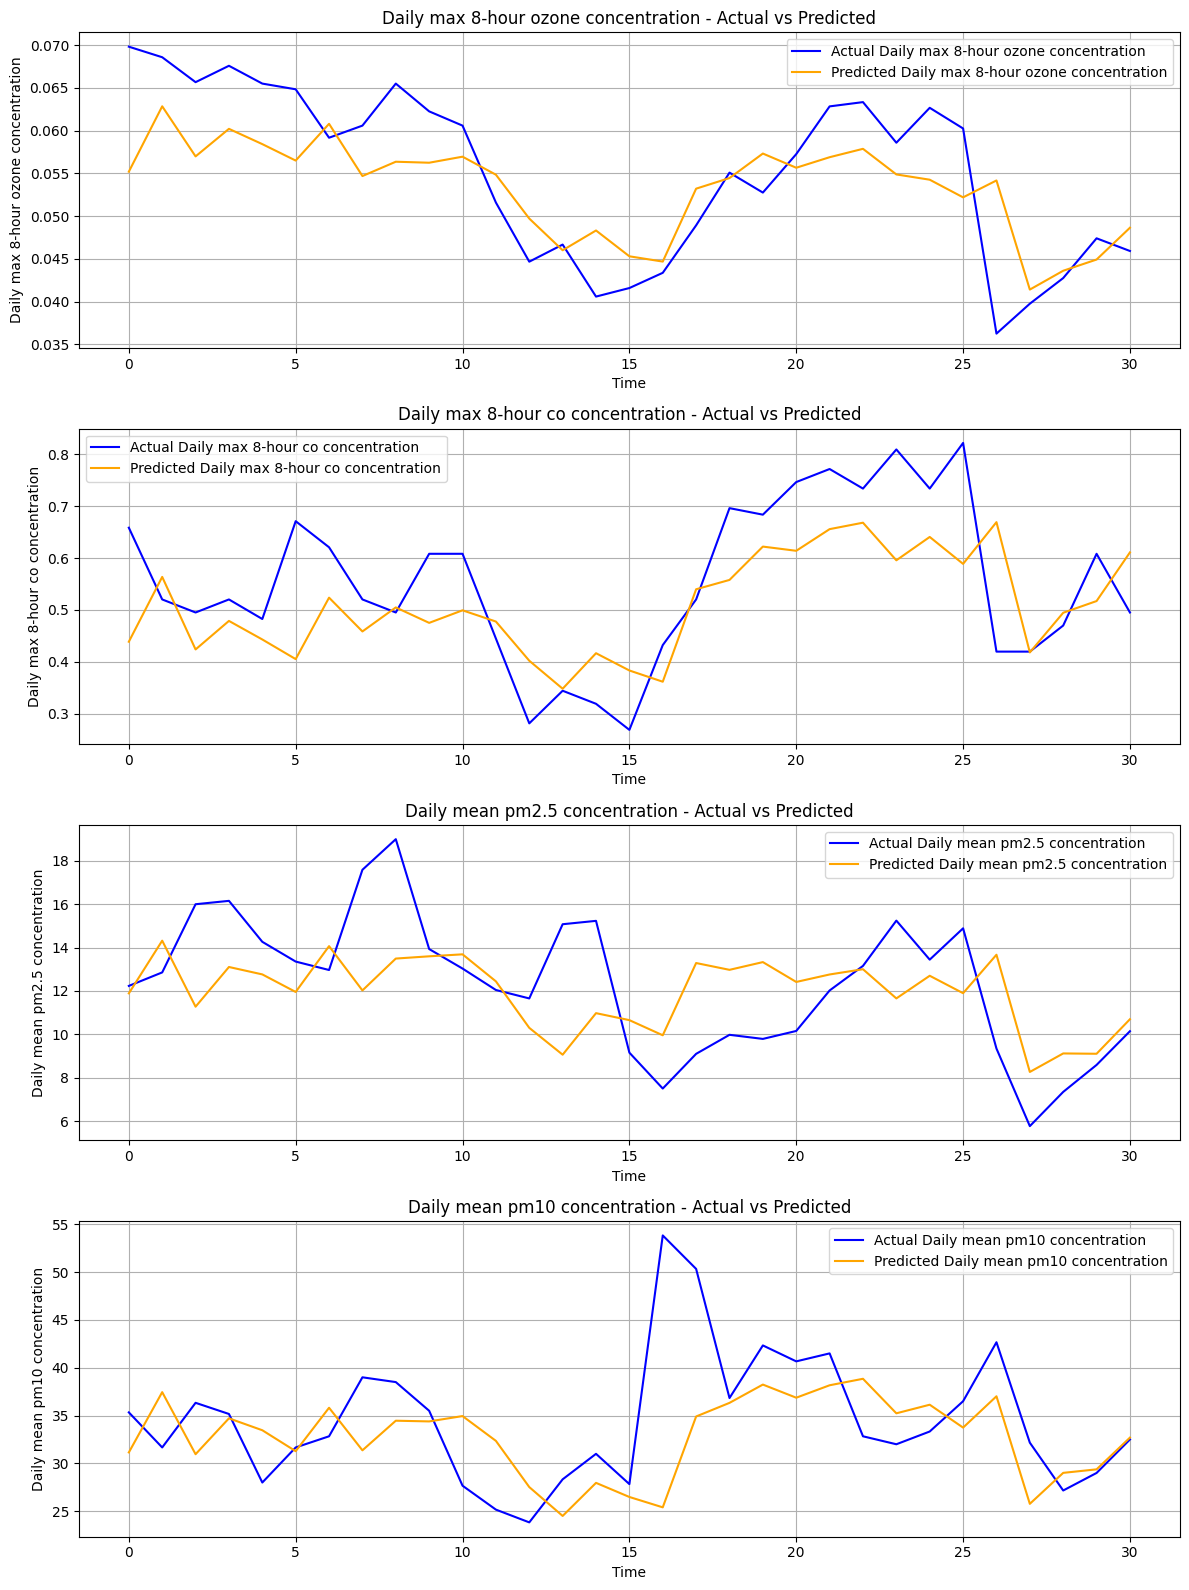

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the CSV files into DataFrames
ozone_data = pd.read_csv('/content/Daily_Avg_Ozone.csv')
co_data = pd.read_csv('/content/Daily_Avg_CO.csv')
pm25_data = pd.read_csv('/content/Daily_Avg_PM2.5.csv')
pm10_data = pd.read_csv('/content/Daily_Avg_PM10.csv')

# Ensure the date column is in datetime format
ozone_data['Date'] = pd.to_datetime(ozone_data['Date'])
co_data['Date'] = pd.to_datetime(co_data['Date'])
pm25_data['Date'] = pd.to_datetime(pm25_data['Date'])
pm10_data['Date'] = pd.to_datetime(pm10_data['Date'])

# Merge all DataFrames on 'date'
merged_data = ozone_data.merge(co_data, on='Date').merge(pm25_data, on='Date').merge(pm10_data, on='Date')

# Rename columns for clarity
merged_data.columns = ['Date', 'Daily Max 8-hour Ozone Concentration', 'Daily Max 8-hour CO Concentration', 'Daily Mean PM2.5 Concentration', 'Daily Mean PM10 Concentration']

# Drop the 'date' column for modeling (keep it for visualization if needed later)
data_values = merged_data.drop(columns=['Date']).values

# Get the last date in the dataset
last_date = merged_data['Date'].max()

# Calculate the cutoff date for the last two months
cutoff_date = last_date - timedelta(days=60)

# Split the dataset
train_data = merged_data[merged_data['Date'] < cutoff_date]
test_data = merged_data[merged_data['Date'] >= cutoff_date]

# Drop the 'date' column for scaling and model input
train_values = train_data.drop(columns=['Date']).values
test_values = test_data.drop(columns=['Date']).values

# Scale the data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_values)
scaled_test = scaler.transform(test_values)
scaled_data = scaler.fit_transform(data_values)

# Create sequences for training and testing
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])  # Input sequence
        y.append(data[i+seq_length, :])   # Target sequence
    return np.array(X), np.array(y)

seq_length = 30
X_train, y_train = create_sequences(scaled_train, seq_length)
X_test, y_test = create_sequences(scaled_test, seq_length)
X, y = create_sequences(scaled_data, seq_length)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X.shape[2])))
model.add(Dropout(0.2))  # Prevent overfitting
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))  # Intermediate dense layer
model.add(Dense(4))   # Output layer with 4 neurons for ozone, CO, PM2.5, and PM10

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and test data for interpretability
y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(y_pred)

# Plot actual vs predicted for each variable
fig, axs = plt.subplots(4, 1, figsize=(12, 16))
variables = ['Daily Max 8-hour Ozone Concentration', 'Daily Max 8-hour CO Concentration', 'Daily Mean PM2.5 Concentration', 'Daily Mean PM10 Concentration']


for i, ax in enumerate(axs):
    ax.plot(y_test_unscaled[:, i], label=f'Actual {variables[i].capitalize()}', color='blue')
    ax.plot(y_pred_unscaled[:, i], label=f'Predicted {variables[i].capitalize()}', color='orange')
    ax.set_title(f'{variables[i].capitalize()} - Actual vs Predicted')
    ax.set_xlabel('Time')
    ax.set_ylabel(variables[i].capitalize())
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()


Calculating Accuracy

In [3]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define a function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Initialize lists to store results
mae_results = {}
mape_results = {}

# Variables to evaluate
variables = ['Daily Max 8-hour Ozone Concentration', 'Daily Max 8-hour CO Concentration', 'Daily Mean PM2.5 Concentration', 'Daily Mean PM10 Concentration']

# Calculate MAE and MAPE for each variable
for i, var in enumerate(variables):
    # Extract actual and predicted values for the variable
    actual = y_test_unscaled[:, i]
    predicted = y_pred_unscaled[:, i]

    # Calculate MAE
    mae = mean_absolute_error(actual, predicted)
    mae_results[var] = mae

    # Calculate MAPE (exclude any zero values in actual to avoid division by zero)
    non_zero_indices = actual != 0
    mape = mean_absolute_percentage_error(actual[non_zero_indices], predicted[non_zero_indices])
    mape_results[var] = mape

# Display the results
print("Mean Absolute Error (MAE):")
for var, mae in mae_results.items():
    print(f"{var.capitalize()}: {mae:.2f}")

print("\nMean Absolute Percentage Error (MAPE):")
for var, mape in mape_results.items():
    print(f"{var.capitalize()}: {mape:.2f}%")


Mean Absolute Error (MAE):
Daily max 8-hour ozone concentration: 0.01
Daily max 8-hour co concentration: 0.10
Daily mean pm2.5 concentration: 2.34
Daily mean pm10 concentration: 4.79

Mean Absolute Percentage Error (MAPE):
Daily max 8-hour ozone concentration: 9.95%
Daily max 8-hour co concentration: 18.31%
Daily mean pm2.5 concentration: 19.62%
Daily mean pm10 concentration: 13.09%


In [4]:
# Calculate the range for each variable
ranges = {
    'Daily Max 8-hour Ozone Concentration': y_test_unscaled[:, 0].max() - y_test_unscaled[:, 0].min(),
    'Daily Max 8-hour CO Concentration': y_test_unscaled[:, 1].max() - y_test_unscaled[:, 1].min(),
    'Daily Mean PM2.5 Concentration': y_test_unscaled[:, 2].max() - y_test_unscaled[:, 2].min(),
    'Daily Mean PM10 Concentration': y_test_unscaled[:, 3].max() - y_test_unscaled[:, 3].min()
}

# Calculate MAE for each variable
mae_results = {}
variables = ['Daily Max 8-hour Ozone Concentration', 'Daily Max 8-hour CO Concentration', 'Daily Mean PM2.5 Concentration', 'Daily Mean PM10 Concentration']
for i, var in enumerate(variables):
    mae = mean_absolute_error(y_test_unscaled[:, i], y_pred_unscaled[:, i])
    mae_results[var] = mae

# Calculate accuracy using the formula
accuracy_results = {}
for var in variables:
    accuracy = (1 - (mae_results[var] / ranges[var])) * 100
    accuracy_results[var] = accuracy

# Display the results
print("Model Accuracy:")
for var, acc in accuracy_results.items():
    print(f"{var.capitalize()}: {acc:.2f}%")


Model Accuracy:
Daily max 8-hour ozone concentration: 83.84%
Daily max 8-hour co concentration: 81.99%
Daily mean pm2.5 concentration: 82.33%
Daily mean pm10 concentration: 84.02%


In [5]:
import pandas as pd
import numpy as np

# Calculate percent error
percent_error = np.abs((y_test_unscaled - y_pred_unscaled) / y_test_unscaled) * 100

# Create DataFrames for each predictor
predictors = ['Ozone', 'CO', 'PM2.5', 'PM10']
columns = ['Date', 'Predicted Value', 'Actual Value', 'Percent Error']

for i, predictor in enumerate(predictors):
    df = pd.DataFrame({
        'Date': test_data['Date'][seq_length:].reset_index(drop=True),
        'Predicted Value': y_pred_unscaled[:, i],
        'Actual Value': y_test_unscaled[:, i],
        'Percent Error': percent_error[:, i]
    })
    df.to_csv(f'{predictor}_predictions.csv', index=False)

print("CSV files for each predictor have been created successfully.")

CSV files for each predictor have been created successfully.


In [6]:
df = pd.read_csv('/content/Ozone_predictions.csv')
df.head()

,Date,Predicted Value,Actual Value,Percent Error
0,2024-10-02,0.055194,0.069818,20.945579
1,2024-10-03,0.062843,0.068583,8.369211
2,2024-10-04,0.056983,0.065667,13.224298
3,2024-10-05,0.060206,0.067583,10.915659
4,2024-10-06,0.058419,0.065500,10.811363
